# Install and Import Dependencies:

In [ ]:
!pip install kaggle

#machine learning
!pip install catboost

     |████████████████████████████████| 67.3MB 74kB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import time

import matplotlib.pyplot as plt

# Import Dataset from Kaggle:

In [ ]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/324k [00:00<?, ?B/s]
100% 324k/324k [00:00<00:00, 48.5MB/s]
  0% 0.00/332k [00:00<?, ?B/s]
100% 332k/332k [00:00<00:00, 105MB/s]
  0% 0.00/336k [00:00<?, ?B/s]
100% 336k/336k [00:00<00:00, 108MB/s]
  0% 0.00/319k [00:00<?, ?B/s]
100% 319k/319k [00:00<00:00, 102MB/s]
  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 94.7MB/s]
  0% 0.00/321k [00:00<?, ?B/s]
100% 321k/321k [00:00<00:00, 105MB/s]
  0% 0.00/320k [00:00<?, ?B/s]
100% 320k/320k [00:00<00:00, 86.1MB/s]
  0% 0.00/319k [00:00<?, ?B/s]
100% 319k/319k [00:00<00:00, 104MB/s]
  0% 0.00/324k [00:00<?, ?B/s]
100% 324k/324k [00:00<00:00, 170MB/s]
  0% 0.00/329k [00:00<?, ?B/s]
100% 329k/329k [00:00<00:00, 108MB/s]
  0% 0.00/360k [00:00<?, ?B/s]
100% 360k/360k [00:00<00:00, 93.7MB/s]
  0% 0.00/320k [00:00<?, ?B/s]
100% 320k/320k [00:00<00:00, 106MB/s]
  0% 0.00/330k [00:00<?, ?B/s]
100% 330k/330k [00:00<00:00, 108MB/s]
  0% 0.00/325k [00:00<?, ?B/s]
100% 325k/325k [00:00<00:00, 103MB/s]
  0% 0.00/325k [00:00<?, ?B/s]

In [ ]:
!ls

sample_data	       seg_0042cc.csv  seg_006e4a.csv  seg_00e5f7.csv
sample_submission.csv  seg_004314.csv  seg_007a37.csv  seg_00f3b9.csv
seg_00030f.csv	       seg_004cd2.csv  seg_00a37e.csv  seg_010eab.csv
seg_0012b5.csv	       seg_004ee5.csv  seg_00be11.csv  seg_0125d9.csv
seg_00184e.csv	       seg_004f1f.csv  seg_00c35b.csv  train.csv.zip
seg_003339.csv	       seg_00648a.csv  seg_00cc91.csv


## Extract Data:

In [ ]:
!unzip train.csv.zip


Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
!unzip -d test/ test12.zip

Archive:  test12.zip
   creating: test/test/
  inflating: test/test/seg_0b9ad8.csv  
  inflating: test/test/seg_0b9ba3.csv  
  inflating: test/test/seg_00a37e.csv  
  inflating: test/test/seg_0a0fbb.csv  
  inflating: test/test/seg_0a42ba.csv  
  inflating: test/test/seg_0aa0fb.csv  
  inflating: test/test/seg_0a97c4.csv  
  inflating: test/test/seg_0b07c7.csv  
  inflating: test/test/seg_0b3b94.csv  
  inflating: test/test/seg_0b4b24.csv  
  inflating: test/test/seg_0a1bd0.csv  
  inflating: test/test/seg_0a45a1.csv  


# Data Analysis:

In [ ]:
train_df = pd.read_csv('train.csv', nrows = 6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [ ]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


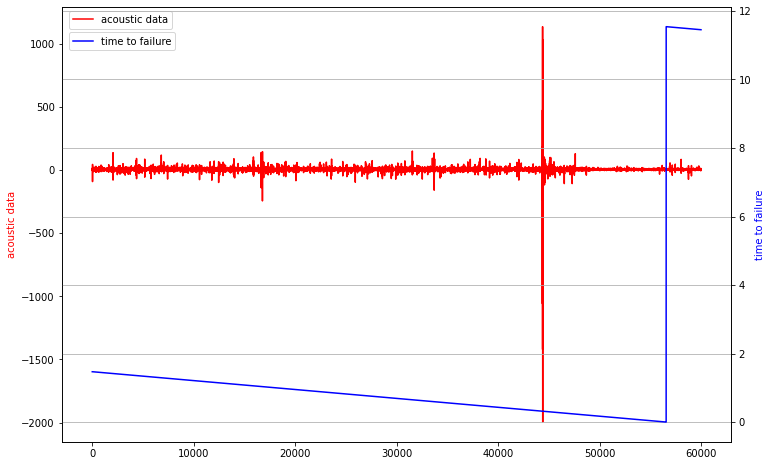

In [ ]:
train_ad_sample = train_df['acoustic_data'].values[::100] # :: means skip by 100
train_ttf_sample = train_df['time_to_failure'].values[::100]

# twinx() - share same X-axis but with diff scales

fig, ax1 = plt.subplots(figsize=(12, 8))

plt.plot(train_ad_sample, color='r')
ax1.set_ylabel('acoustic data', color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))

ax2 = ax1.twinx()

plt.plot(train_ttf_sample, color='b')
ax2.set_ylabel('time to failure', color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))

plt.grid(True)


# Feature Engineering:

In [ ]:
def gen_features(X):
    strain = []
    #strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    #strain.append(X.kurtosis())
    #strain.append(X.skew())
    #strain.append(np.quantile(X,0.01))
    #strain.append(np.quantile(X,0.05))
    #strain.append(np.quantile(X,0.95))
    #strain.append(np.quantile(X,0.99))
    #strain.append(np.abs(X).min())
    strain.append(np.abs(X).max())
    #strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

# Prepare Training Data:

In [ ]:
train = pd.read_csv('train.csv', iterator = True, chunksize = 150000,
                    dtype = {'acoustic_data': np.int16, 'time_to_failure': np.float64})  #Returns TextFileReader object for Iteration
X_train = pd.DataFrame()
y_train = pd.Series()


for df in train:
  ch = gen_features(df['acoustic_data'])
  X_train = X_train.append(ch, ignore_index=True)
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [ ]:
X_train.describe()

,0,1,2,3,4
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,6.547788,-149.190942,163.522288,170.046246,5.750165
std,8.503939,265.087984,272.930331,296.887015,8.339211
min,2.802720,-5515.000000,23.000000,23.000000,2.589085
25%,4.478637,-154.000000,92.000000,94.000000,3.862810
50%,5.618798,-111.000000,123.000000,127.000000,4.781513
75%,6.880904,-79.000000,170.000000,175.000000,5.887947
max,153.703569,-15.000000,5444.000000,5515.000000,150.432368


In [ ]:
y_train.describe()

count    4195.000000
mean        5.683670
std         3.673246
min         0.006398
25%         2.635348
50%         5.358796
75%         8.177500
max        16.103196
dtype: float64

In [ ]:
# scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train) # compute the mean and standard deviation to be used for later scaling
X_train_scaled = scaler.transform(X_train)

# Training Time:

In [ ]:
#random forest

rand_forest = RandomForestRegressor(n_estimators=100, criterion='mae', oob_score=True, n_jobs=-1)
start_time = time.time()
rand_forest.fit(X_train_scaled, y_train.values.flatten())
print("Training Time:", time.time()-start_time)
print('Training Score:', rand_forest.score(X_train_scaled, y_train.values.flatten()))
rand_forest.oob_score_

Training Time: 19.917041540145874
Training Score: 0.9039005030609523


0.3253860917114966

In [ ]:
rand_forest.feature_importances_

array([0.43287549, 0.15564678, 0.11407907, 0.11084638, 0.18655229])

# Evaluate Models:

## Process test data:

In [ ]:
X_test = pd.DataFrame()
seg_ids = pd.Series()

for file in os.listdir('/content/test/test'):
  data = pd.read_csv(os.path.join('/content/test/test', file), dtype = {'acoustic_data': np.int16})
  data_fet = gen_features(data['acoustic_data'])
  X_test = X_test.append(data_fet, ignore_index=True)
  seg_ids = seg_ids.append(pd.Series(os.path.splitext(file)[0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
X_test_scaled = scaler.transform(X_test)

In [ ]:
forest_pred = rand_forest.predict(X_test_scaled)

In [ ]:
forest_pred

array([7.62033553, 3.68375584, 7.67983085, 4.06499375, 8.6012687 ,
       2.08584952, 9.56680251, 6.47751457, 3.93804926, 0.97908078,
       6.23379172, 8.16662463])